# LSTM neural network used to predict stock prices of Microsoft (MSFT)


### Imports and Data

In [297]:
#Basic imports and set-up

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

#Gathering the Data: 

#We will be using yfinance: 

import yfinance as yf
msft=yf.Ticker('MSFT')
msft_info=msft.history(period='max')
msft_info= msft_info.reset_index() #This is to make the date a column as well, so we can call it

In [297]:
#Basic imports and set-up

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

#Gathering the Data: 

#We will be using yfinance: 

import yfinance as yf
msft=yf.Ticker('MSFT')
msft_info=msft.history(period='max')
msft_info= msft_info.reset_index() #This is to make the date a column as well, so we can call it

In [99]:
#We will only be using 2 columns from this data frame: date and close. Let's create a data frame with just those 2 columns

msft_close=msft_info[['Date', 'Close']]
#msft_close.index=msft_close.pop('Date') #Make the date back to being the index of this new dataframe 

Text(0.5, 0, 'Year')

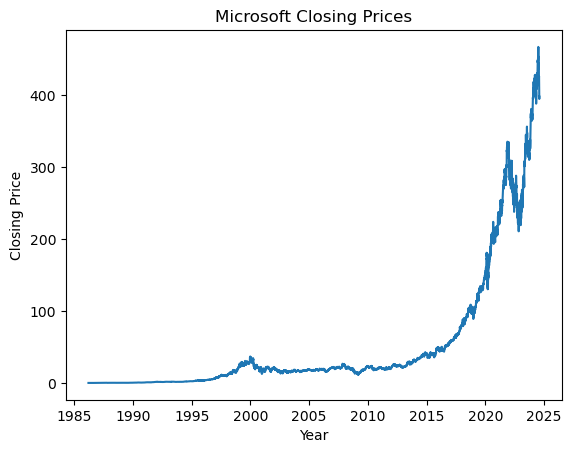

In [189]:
#We can visualize this dataframe now, using the matplotlib library 

plt.plot(msft_close['Date'], msft_close['Close'])
plt.title('Microsoft Closing Prices')
plt.ylabel('Closing Price')
plt.xlabel('Year')

In [299]:
# We need to create the labels, and because this is an LSTM, we have to go back and find what 
#the prices before the date we want the prices for can tells us about curent prices 

n=3 # default, this is the number of days prior that will inform the current closing price 

for i in range (1,n+1): 
    msft_close[f'Close_{i}_days_ago'] = msft_close['Close'].shift(i)

msft_close.dropna(inplace=True)

In [157]:
#Now, let's create separate dataframes for the date, the close price (which is the label) and the prior prices. 
#We also need to make them all arrays for our model, which is why we use the .values attribute of numpy 

#The dates array is useful to find the length of the array we need for our model 
dates = msft_close['Date'].values

#The y array holds all our data labels 
y = msft_close['Close'].values

#The X array holds all our close prices from the three days before for every date. We have to reshape it for the LSTM 
features = msft_close[['Close_1_days_ago', 'Close_2_days_ago', 'Close_3_days_ago']].values
X = features.reshape(len(dates), features.shape[1], 1)

### Splitting, Making and Evaluating the Data

In [159]:
#Now we will use a train/validation/test split 

#Our training dataset will be 80% of our data: 
int80=int(len(dates) * 0.8)
dates_train, X_train, y_train= dates[:int80], X[:int80], y[:int80]

#Our validation dataset will be 10% of our dataset (not used for training): 
int90=int(len(dates) * 0.9)
dates_val, X_val, y_val= dates[int80:int90], X[int80:int90], y[int80:int90]

#Our testing data will be the last 10% of the data we have left: 
dates_test, X_test, y_test= dates[int90:], X[int90:], y[int90:]

In [169]:
# Now we will make our model

#We need to import some functions: 

from tensorflow.keras.models import Sequential 
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras import layers 

model=Sequential() 
model.add(layers.Input((3,1)))
model.add(layers.LSTM(64))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1)) #Output layer, regression task 
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mean_absolute_error'])

In [171]:
#Now, let's fit the model 

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

Epoch 1/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 197.5169 - mean_absolute_error: 8.5758 - val_loss: 5750.7046 - val_mean_absolute_error: 61.4666
Epoch 2/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step - loss: 0.4801 - mean_absolute_error: 0.4077 - val_loss: 5359.9136 - val_mean_absolute_error: 58.0776
Epoch 3/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step - loss: 0.3624 - mean_absolute_error: 0.3619 - val_loss: 5313.5195 - val_mean_absolute_error: 57.2440
Epoch 4/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step - loss: 0.3504 - mean_absolute_error: 0.3476 - val_loss: 5333.2778 - val_mean_absolute_error: 56.9620
Epoch 5/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step - loss: 0.3285 - mean_absolute_error: 0.3399 - val_loss: 5396.0757 - val_mean_absolute_error: 57.0799
Epoch 6/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step - loss: 0.3002 - mean_absolute_error: 0.3280 - val_loss: 5466.8896 - val_mean_absolute_error: 57.2731
Epoch 7/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step - l

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 595us/step


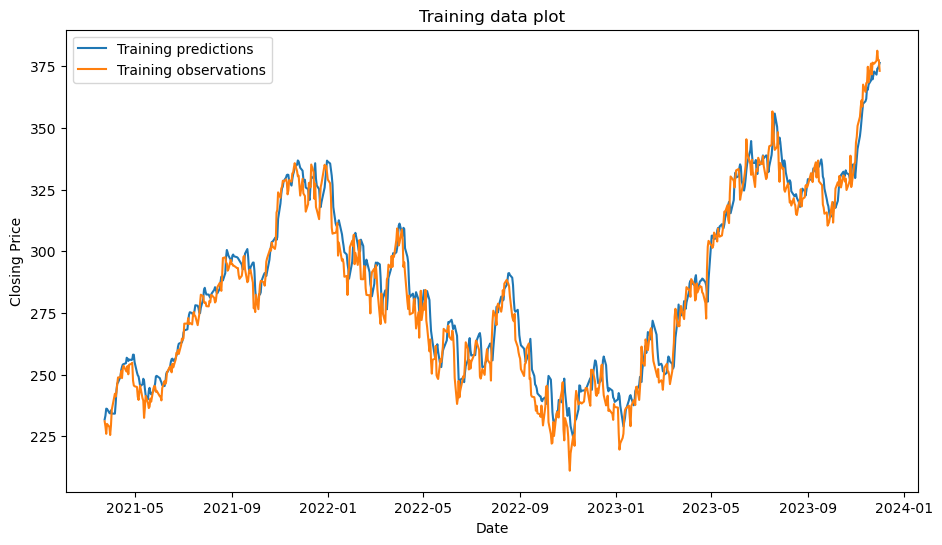

In [287]:
#Now, let's use the model to predict our data: 

#First, let's visualize this with the training data 

training_predictions=model.predict(X_train).flatten()
plt.figure(figsize=(11,6))
plt.plot(dates_train, training_predictions)
plt.plot(dates_train, y_train)
plt.title('Training data plot')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend(['Training predictions', 'Training observations'])

#We can see that the lines for observations and predictions are almost overlapping. This makes sense, because our model has seen this data before

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


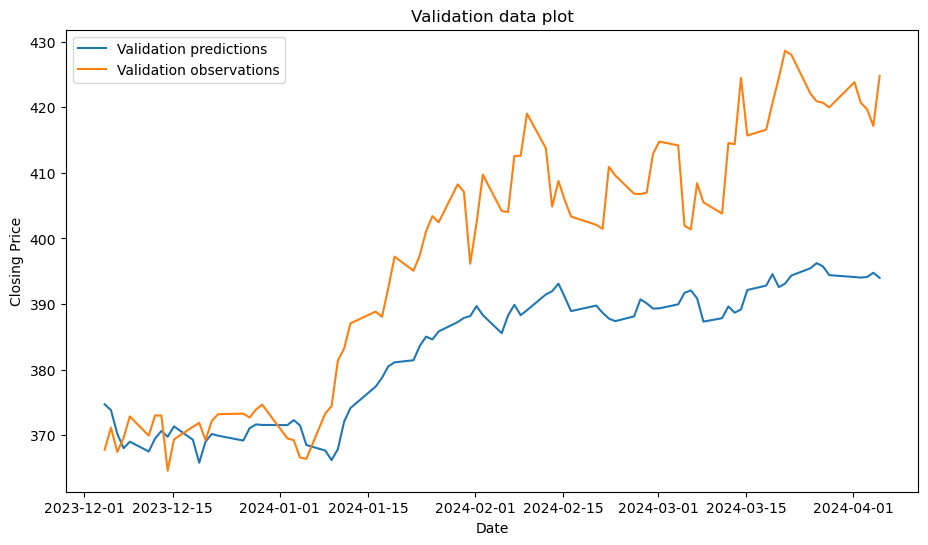

In [285]:
#Now let's do this with our validation data, which our model has NOT been fitted to 

validation_predictions=model.predict(X_val).flatten()
plt.figure(figsize=(11,6))
plt.plot(dates_val, validation_predictions)
plt.plot(dates_val, y_val)
plt.title('Validation data plot')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend(['Validation predictions', 'Validation observations'])

# We can see that the predictions are far below the actual closing price observations. 

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step


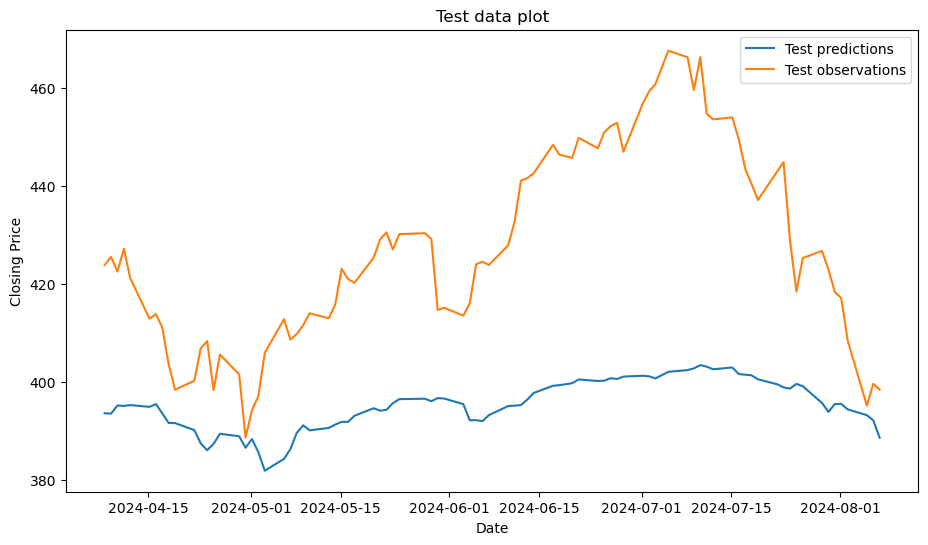

In [283]:
#Let's see how well the LSTM does on the test set 

test_predictions=model.predict(X_test).flatten()
plt.figure(figsize=(11,6))
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.title('Test data plot')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend(['Test predictions', 'Test observations'])

#The model performs even worse. This is probably because the prices increase (seemingly) exponentially in the last 20% of the dataset. 
#Our training set does not include data from the last 20% of the overall dataset, which is why the model performs so poorly. 

### Making our model more accurate: using a shorter history for our model

In [239]:
#Instead, let's use a more recent date that is more representative of where our data is currently. 
#Let's use the date March 23, 2020 (arbitrarily). We have to change our dataset now to only include dates on and after that. 

cutoff_date = pd.Timestamp('2021-03-23').tz_localize('America/New_York') #Make sure my cutoff is the correct datatype 
msft_recent=msft_close[msft_close['Date']>=cutoff_date]


In [241]:
#We now need to make arrays again of our data 

#The dates array is useful to find the length of the array we need for our model and to visualize our results 
dates = msft_recent['Date'].values

#The y array holds all our data labels 
y = msft_recent['Close'].values

#The X array holds all our close prices from the three days before for every date. We have to reshape it for the LSTM 
features = msft_recent[['Close_1_days_ago', 'Close_2_days_ago', 'Close_3_days_ago']].values
X = features.reshape(len(dates), features.shape[1], 1)

In [243]:
#We will now resplit our data based on this: (the code does not change, you just have to run it again) 

#Our training dataset will be 80% of our data: 
int80=int(len(dates) * 0.8)
dates_train, X_train, y_train= dates[:int80], X[:int80], y[:int80]

#Our validation dataset will be 10% of our dataset (not used for training): 
int90=int(len(dates) * 0.9)
dates_val, X_val, y_val= dates[int80:int90], X[int80:int90], y[int80:int90]

#Our testing data will be the last 10% of the data we have left: 
dates_test, X_test, y_test= dates[int90:], X[int90:], y[int90:]

In [255]:
#Let's run our model again (no code changes): 

model=Sequential() 
model.add(layers.Input((3,1)))
model.add(layers.LSTM(64))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1)) #Output layer, regression task 
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=250)

Epoch 1/250
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 81630.6250 - mean_absolute_error: 283.3750 - val_loss: 157582.0312 - val_mean_absolute_error: 396.4823
Epoch 2/250
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 80783.5156 - mean_absolute_error: 281.7981 - val_loss: 156431.4688 - val_mean_absolute_error: 395.0284
Epoch 3/250
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 79764.1016 - mean_absolute_error: 279.9795 - val_loss: 152061.6562 - val_mean_absolute_error: 389.4584
Epoch 4/250
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 75565.8047 - mean_absolute_error: 272.4236 - val_loss: 143538.3281 - val_mean_absolute_error: 378.3569
Epoch 5/250
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 68720.9141 - mean_absolute_error: 259.6548 - val_loss: 129375.6953 - val_mean_absolute_error: 359.1543
Epoch 6/250
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 58892.9062 - mean_absolute_error: 239.6771 - val_loss: 108063.9375 - val_mean_absolute_error: 328.1442
Epoch 7/250
22/22 ━━━━━━━━━━

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 339us/step


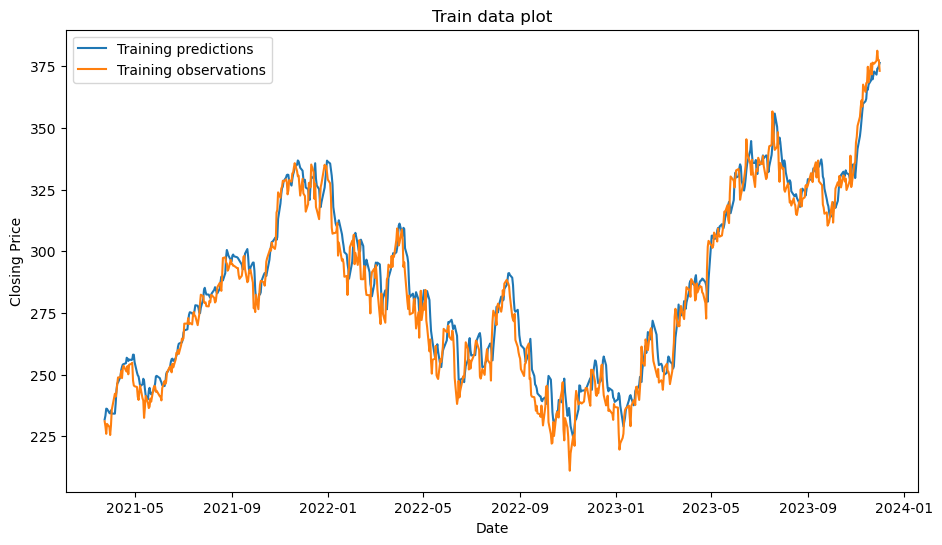

In [281]:
#That went far faster! Let's do the same plots for training, validation, and testing 

training_predictions=model.predict(X_train).flatten()
plt.figure(figsize=(11,6))
plt.plot(dates_train, training_predictions)
plt.plot(dates_train, y_train)
plt.title('Train data plot')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend(['Training predictions', 'Training observations'])

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step


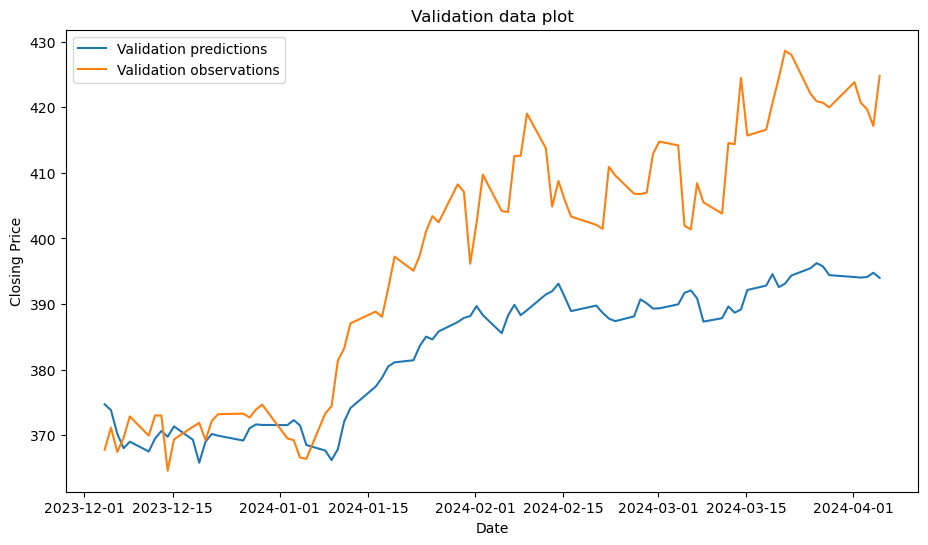

In [277]:
#Validation data set  

validation_predictions=model.predict(X_val).flatten()
plt.figure(figsize=(11,6))
plt.plot(dates_val, validation_predictions)
plt.plot(dates_val, y_val)
plt.title('Validation data plot')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend(['Validation predictions', 'Validation observations'])

#We can see that the predictions somewhat keep up with the reality 

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 806us/step


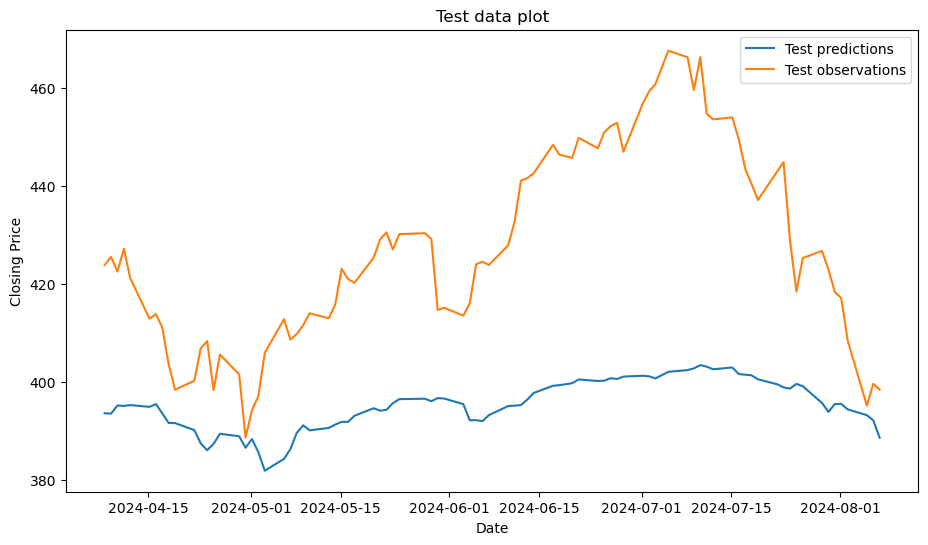

In [279]:
#Testing data set 

test_predictions=model.predict(X_test).flatten()
plt.figure(figsize=(11,6))
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.title('Test data plot')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend(['Test predictions', 'Test observations'])

#The predictions for the testing data are not at all reflective of the observations. 
#However, they do portray the overall movement of the stock's closing price.

### Trying to make our model even better: scaling our data's features 

In [323]:
# This model is not very good at predicting stock prices. Let's instead try to scale the data using MinMaxScaler from sklearn

from sklearn.preprocessing import MinMaxScaler 

#Let's go back and get all of our data we used: 
dates = msft_close['Date'].values

#The y array holds all our data labels 
y = msft_close['Close'].values

#The X array holds all our close prices from the three days before for every date. We have to reshape it for the LSTM 
features = msft_close[['Close_1_days_ago', 'Close_2_days_ago', 'Close_3_days_ago']].values
X = features.reshape(len(dates), features.shape[1], 1)

#Our training dataset will be 80% of our data: 
int80=int(len(dates) * 0.8)
dates_train, X_train, y_train= dates[:int80], X[:int80], y[:int80]

#Our validation dataset will be 10% of our dataset (not used for training): 
int90=int(len(dates) * 0.9)
dates_val, X_val, y_val= dates[int80:int90], X[int80:int90], y[int80:int90]

#Our testing data will be the last 10% of the data we have left: 
dates_test, X_test, y_test= dates[int90:], X[int90:], y[int90:]

## Now, let's scale the X values: 

scaler = MinMaxScaler()

#MinMaxScaler can only accept 2D objects, so let's reshape X_train and X_test and then scale them 
X_train_2d = X_train.reshape(-1, 1)
X_val_2d=X_val.reshape(-1,1)
X_test_2d=X_test.reshape(-1,1)

X_train_scaled_2d=scaler.fit_transform(X_train_2d)
X_val_scaled_2d=scaler.fit_transform(X_val_2d)
X_test_scaled_2d=scaler.transform(X_test_2d)

#Now, let's reshape them back 

X_train_scaled = X_train_scaled_2d.reshape(X_train.shape)
X_val_scaled = X_val_scaled_2d.reshape(X_val.shape)
X_test_scaled = X_test_scaled_2d.reshape(X_test.shape)

#Now, let's refit our model 

model.fit(X_train_scaled, y_train, validation_data=(X_val, y_val), epochs=150)

Epoch 1/150
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 792us/step - loss: 9.3441 - mean_absolute_error: 1.5364 - val_loss: 13458.7383 - val_mean_absolute_error: 113.3578
Epoch 2/150
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step - loss: 0.2065 - mean_absolute_error: 0.2928 - val_loss: 13079.2832 - val_mean_absolute_error: 111.7614
Epoch 3/150
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step - loss: 0.2118 - mean_absolute_error: 0.2895 - val_loss: 12801.6572 - val_mean_absolute_error: 110.5811
Epoch 4/150
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step - loss: 0.2214 - mean_absolute_error: 0.2856 - val_loss: 12527.6865 - val_mean_absolute_error: 109.4191
Epoch 5/150
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step - loss: 0.2045 - mean_absolute_error: 0.2776 - val_loss: 12211.9111 - val_mean_absolute_error: 108.0705
Epoch 6/150
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 918us/step - loss: 0.1965 - mean_absolute_error: 0.2853 - val_loss: 11983.0723 - val_mean_absolute_error: 107.0758
Epoch 7/150
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 78

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step


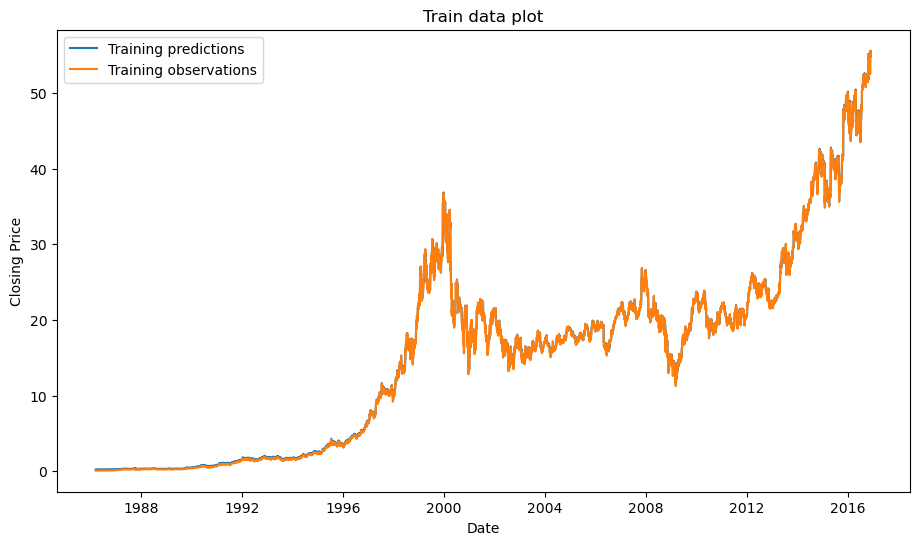

In [327]:
training_predictions=model.predict(X_train_scaled).flatten()
plt.figure(figsize=(11,6))
plt.plot(dates_train, training_predictions)
plt.plot(dates_train, y_train)
plt.title('Train data plot')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend(['Training predictions', 'Training observations'])

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step


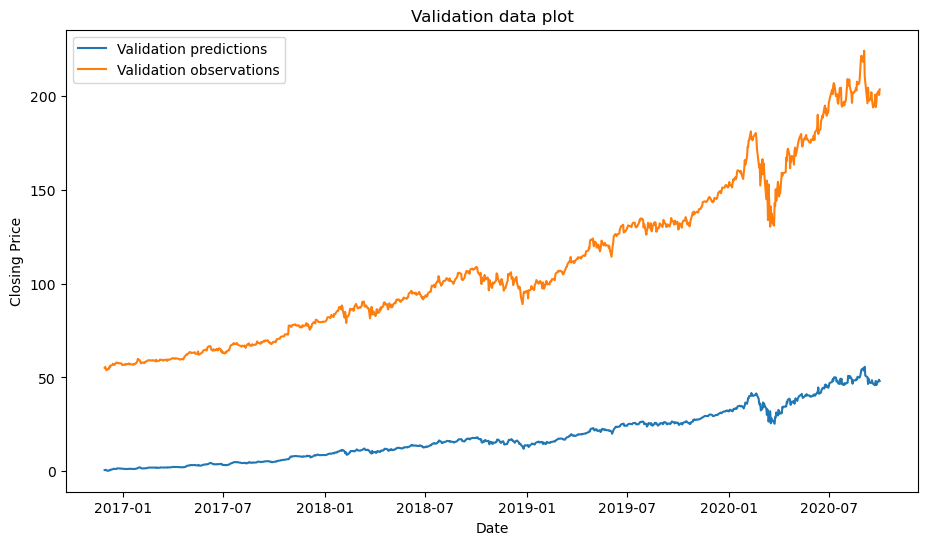

In [329]:
validation_predictions=model.predict(X_val_scaled).flatten()
plt.figure(figsize=(11,6))
plt.plot(dates_val, validation_predictions)
plt.plot(dates_val, y_val)
plt.title('Validation data plot')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend(['Validation predictions', 'Validation observations'])

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 475us/step


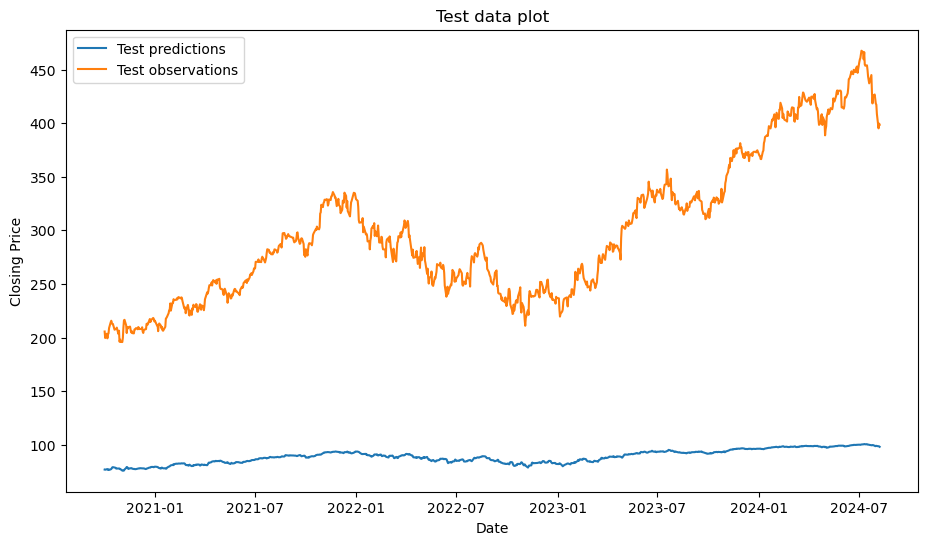

In [331]:
test_predictions=model.predict(X_test).flatten()
plt.figure(figsize=(11,6))
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.title('Test data plot')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend(['Test predictions', 'Test observations'])


### Let's mix both of the previous approaches: let's scale the data (using np.log), and use a cutoff date closer to the current date

In [357]:
#Let's go back and get all of our data we used: 

#Let's find an arbitrary cutoff date: 

cutoff_date = pd.Timestamp('2022-03-23').tz_localize('America/New_York') #Make sure my cutoff is the correct datatype 
msft_recent=msft_close[msft_close['Date']>=cutoff_date]

#Let's create arrays (again), but log and X and y arrays 
#The dates give us information to visualize our findings 
dates = msft_recent['Date'].values

#The y array holds all our data labels 
y = np.log(msft_recent['Close']).values

#The X array holds all our close prices from the three days before for every date. We have to reshape it for the LSTM 
features = np.log(msft_recent[['Close_1_days_ago', 'Close_2_days_ago', 'Close_3_days_ago']]).values
X = features.reshape(len(dates), features.shape[1], 1)

#Our training dataset will be 80% of our data: 
int80=int(len(dates) * 0.8)
dates_train, X_train, y_train= dates[:int80], X[:int80], y[:int80]

#Our validation dataset will be 10% of our dataset (not used for training): 
int90=int(len(dates) * 0.9)
dates_val, X_val, y_val= dates[int80:int90], X[int80:int90], y[int80:int90]

#Our testing data will be the last 10% of the data we have left: 
dates_test, X_test, y_test= dates[int90:], X[int90:], y[int90:]

In [352]:
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1615 - mean_absolute_error: 0.3509 - val_loss: 0.0310 - val_mean_absolute_error: 0.1754
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0238 - mean_absolute_error: 0.1281 - val_loss: 0.0752 - val_mean_absolute_error: 0.2737
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0156 - mean_absolute_error: 0.1049 - val_loss: 0.0051 - val_mean_absolute_error: 0.0695
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0131 - mean_absolute_error: 0.0940 - val_loss: 0.0366 - val_mean_absolute_error: 0.1907
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0068 - mean_absolute_error: 0.0699 - val_loss: 0.0328 - val_mean_absolute_error: 0.1806
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0055 - mean_absolute_error: 0.0634 - val_loss: 0.0171 - val_mean_absolute_error: 0.1301
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0059 - mean_absolute_error: 0.0661 - val_loss

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


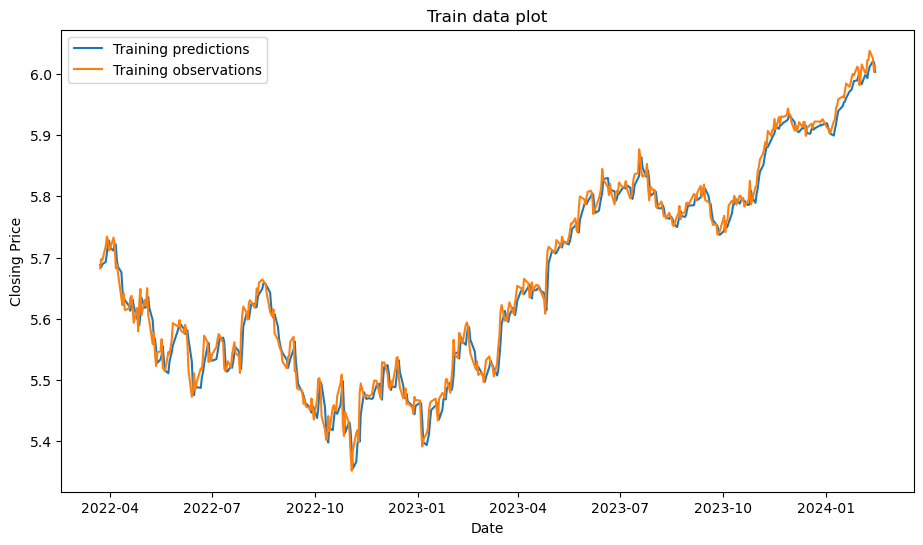

In [361]:
training_predictions=model.predict(X_train).flatten()
plt.figure(figsize=(11,6))
plt.plot(dates_train, training_predictions)
plt.plot(dates_train, y_train)
plt.title('Train data plot')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend(['Training predictions', 'Training observations'])

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


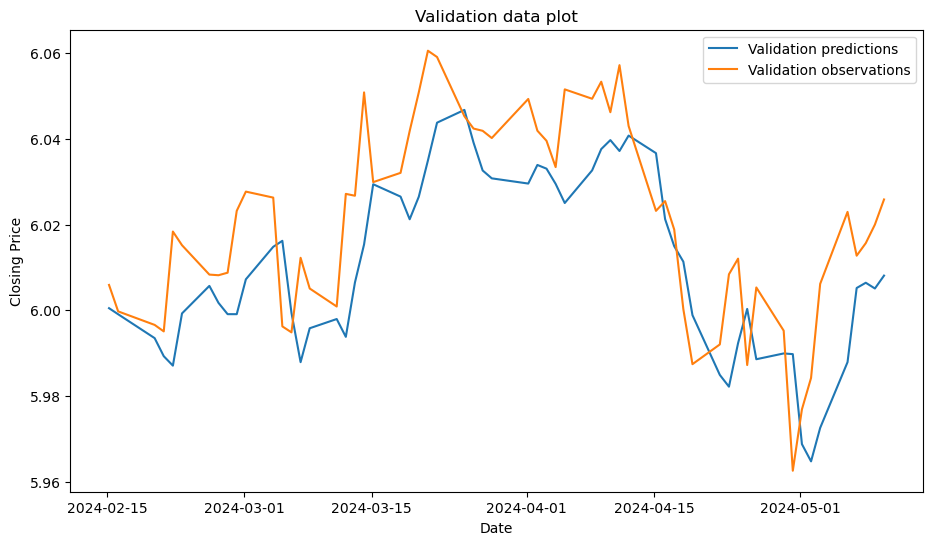

In [359]:
validation_predictions=model.predict(X_val).flatten()
plt.figure(figsize=(11,6))
plt.plot(dates_val, validation_predictions)
plt.plot(dates_val, y_val)
plt.title('Validation data plot')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend(['Validation predictions', 'Validation observations'])

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


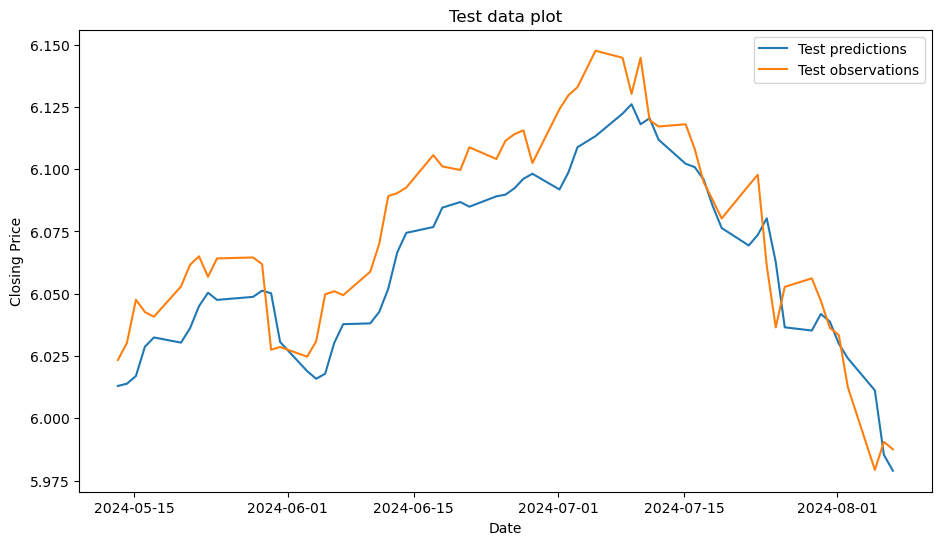

In [354]:
test_predictions=model.predict(X_test).flatten()
plt.figure(figsize=(11,6))
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.title('Test data plot')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend(['Test predictions', 'Test observations'])

## We can conclude that our final model: logarithmic scaling and using a shorter time period makes the best model. I will now try this on a different company to see if we can use the same model on a different company.

In [385]:
ticker='AMD'
info=yf.Ticker(ticker)
data=info.history(period='max')
data= data.reset_index()
data_close=data[['Date', 'Close']]

n=3
for i in range (1,n+1): 
    data_close[f'Close_{i}_days_ago'] = data_close['Close'].shift(i)
data_close.dropna(inplace=True)

cutoff_date = pd.Timestamp('2022-03-23').tz_localize('America/New_York') 
data_recent=data_close[data_close['Date']>=cutoff_date]

dates = data_recent['Date'].values
y = np.log(data_recent['Close']).values
features = np.log(data_recent[['Close_1_days_ago', 'Close_2_days_ago', 'Close_3_days_ago']]).values
X = features.reshape(len(dates), features.shape[1], 1)

int80=int(len(dates) * 0.8)
dates_train, X_train, y_train= dates[:int80], X[:int80], y[:int80] 
int90=int(len(dates) * 0.9)
dates_val, X_val, y_val= dates[int80:int90], X[int80:int90], y[int80:int90]
dates_test, X_test, y_test= dates[int90:], X[int90:], y[int90:]

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)



Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0027 - mean_absolute_error: 0.0402 - val_loss: 0.0013 - val_mean_absolute_error: 0.0256
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0014 - mean_absolute_error: 0.0289 - val_loss: 0.0012 - val_mean_absolute_error: 0.0256
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0012 - mean_absolute_error: 0.0266 - val_loss: 0.0013 - val_mean_absolute_error: 0.0265
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0013 - mean_absolute_error: 0.0279 - val_loss: 0.0017 - val_mean_absolute_error: 0.0321
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0014 - mean_absolute_error: 0.0295 - val_loss: 0.0016 - val_mean_absolute_error: 0.0311
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0013 - mean_absolute_error: 0.0277 - val_loss: 0.0017 - val_mean_absolute_error: 0.0322
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0012 - mean_absolute_error: 0.0273 - val_loss

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 538us/step


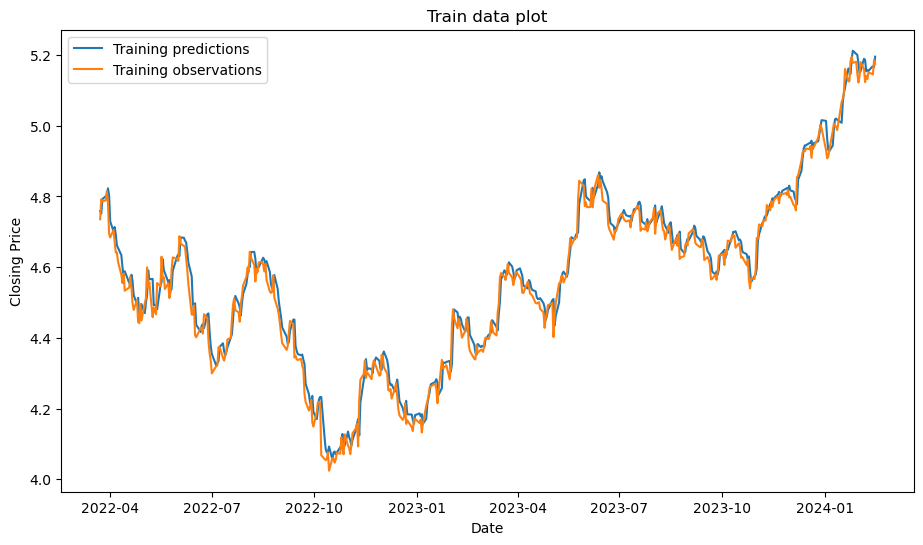

In [387]:
training_predictions=model.predict(X_train).flatten()
plt.figure(figsize=(11,6))
plt.plot(dates_train, training_predictions)
plt.plot(dates_train, y_train)
plt.title('Train data plot')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend(['Training predictions', 'Training observations'])

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


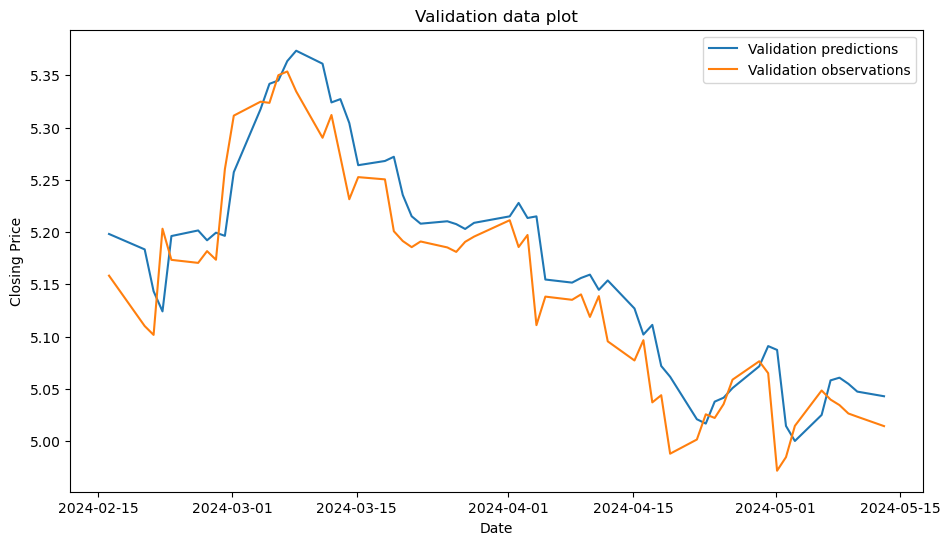

In [389]:
validation_predictions=model.predict(X_val).flatten()
plt.figure(figsize=(11,6))
plt.plot(dates_val, validation_predictions)
plt.plot(dates_val, y_val)
plt.title('Validation data plot')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend(['Validation predictions', 'Validation observations'])

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


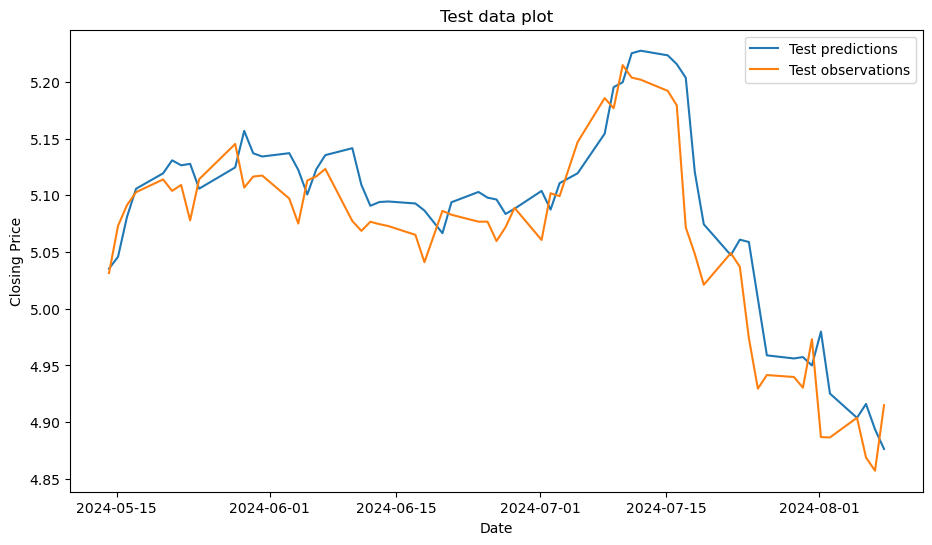

In [391]:
test_predictions=model.predict(X_test).flatten()
plt.figure(figsize=(11,6))
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.title('Test data plot')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend(['Test predictions', 'Test observations'])

## We can see that this model works well for AMD as well, and it should work for other companies also. Success!